### Prereqs:
1. pip install pytest-playwright
2. playwright install
3. playwright install-deps chromium
4. pip install html5lib
5. pip install lxml==5.2.1

Jupyter notebook doesn't run. It nested async loops through Jupyter only works on certain OSs.

Current System Details:  
Ubuntu 24.04.2 LTS (GNU/Linux 5.15.167.4-microsoft-standard-WSL2 x86_64)
System information as of Thu Jul 24 04:14:56 UTC 2025

Python: 3.12.3

Library:  
nest-asyncio==1.6.0  
gradio==5.28.0  
gradio_client==1.10.0  

In [1]:
import os
os.chdir('./../')

In [2]:
import dotenv
import textwrap
from typing import Annotated
from typing_extensions import TypedDict

import gradio as gr
import nest_asyncio
import requests
from IPython.display import Image, display
from langgraph import graph
from langgraph import prebuilt
from langchain.agents import Tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langchain_google_genai import ChatGoogleGenerativeAI

dotenv.load_dotenv(override=True)

from common.constants import Constants
from common.tools.pushover import Pushover

/home/somesh/PythonEnvs/P3.12_LLM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class State(TypedDict):    
    messages: Annotated[list, graph.message.add_messages]

In [4]:
graph_builder = graph.StateGraph(State)

In [5]:
nest_asyncio.apply()

In [6]:
async_browser =  create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()
tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1179/chrome-linux/chrome> version=138.0.7204.23>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1179/chrome-linux/chrome> version=138.0.7204.23>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1179/chrome-linux/chrome> version=138.0.7204.23>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1179/chrome-linux/chrome> version=138.0.7204.23>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/somesh/.cache/ms-playwright/chromium-1179/chrome-linux/chrome> version=138.0.7204.23>),
 GetElementsTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/hom

In [7]:
tool_dict = {tool.name:tool for tool in tools}
navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

In [9]:
await navigate_tool.arun({"url": "https://someshchatterjee.com"})
text = await extract_text_tool.arun({})

In [10]:
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Games More US World Politics
Business Health Entertainment Style Travel Sports Science Climate
Weather Ukraine-Russia War Israel-Hamas War Games Watch Listen Live TV
Subscribe Sign in My Account Settings Newsletters Topics you follow
Sign out Your CNN account Si

In [11]:
tool_push = Tool(name="send_push_notification", func=Pushover.push, description="useful for when you want to send a push notification")

In [12]:
all_tools = tools + [tool_push]

In [13]:
llm = ChatGoogleGenerativeAI(model=Constants.GEMINI_MODEL_LITE)
llm_with_tools = llm.bind_tools(all_tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [14]:
graph_builder = graph.StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", prebuilt.ToolNode(tools=all_tools))
graph_builder.add_conditional_edges("chatbot", prebuilt.tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(graph.START, "chatbot")

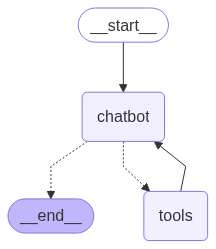

In [15]:
memory = MemorySaver()
state_graph = graph_builder.compile(checkpointer=memory)
display(Image(state_graph.get_graph().draw_mermaid_png()))

In [16]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await state_graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

Exception in thread Thread-9 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/somesh/PythonEnvs/P3.12_LLM/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/somesh/PythonEnvs/P3.12_LLM/lib/python3.12/site-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/somesh/PythonEnvs/P3.12_LLM/lib/python3.12/site-packages/nest_asyncio.py", line 26, in run
    loop = asyncio.get_event_loop()
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/somesh/PythonEnvs/P3.12_LLM/lib/python3.12/site-packages/nest_asyncio.py", line 40, in _get_event_loop
    loop = events.get_event_loop_policy().get_event_loop()
           ^^^^^^

KeyboardInterrupt: 